# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [34]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x185391F5670>, 5)


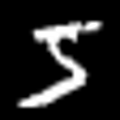

In [35]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [37]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [38]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [39]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################
mu = ims_train.mean()
std = ims_train.std()

We normalize the data as below.

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [41]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [42]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
dl_test = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [43]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [44]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        layers += [nn.Linear(nInput, nHidden), act_fn] + [nn.Linear(nHidden, nHidden), act_fn] * (nLayer - 2) + [nn.Linear(nHidden, nOutput)]
        
        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [45]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [46]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [4]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [3]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [49]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [50]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332973
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.427681
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.587430
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.239458
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.381015
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.315657
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.261768
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.392226
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.491964
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.313111

Train set: Average loss: 0.5079, Accuracy: 52522/60000 (87.5%)


Test set: Average loss: 0.2580, Accuracy: 9254/10000 (92.540%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.185126
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.197311
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.126215
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.095334
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.142520
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.166573
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.191344
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [51]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 10
nHidden = 128
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 5
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309786
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.589348
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.361264
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.423677
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.163260
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.163675
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.082744
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.185911
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.085092
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.224636

Train set: Average loss: 0.0788, Accuracy: 52096/60000 (86.8%)


Test set: Average loss: 0.1692, Accuracy: 9489/10000 (94.890%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.075961
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.296088
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.206770
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.050533
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.076995
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.058114
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.199145
Train Epoch: 2 [44800/60000 (75%

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [21]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0), nn.ReLU(),
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25), 
                                   nn.Flatten(),
                                   nn.Linear(in_features=9216, out_features=128), nn.ReLU(), nn.Dropout(0.5), 
                                   nn.Linear(in_features=128, out_features=10))

    def forward(self, x):
        return self.model(x)


In [22]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [23]:
optimizer = optim.Adam(cnn.parameters())

In [24]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296372
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.279110
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.045890
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.147026
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077818
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.193334
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.121639
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.080198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.092801
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.079665

Train set: Average loss: 0.0266, Accuracy: 56756/60000 (94.6%)


Test set: Average loss: 0.0402, Accuracy: 9868/10000 (98.680%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034754
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.072067
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.048548
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.030922
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.122199
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.048096
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.014356
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: 10%


## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [3]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [4]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [5]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [6]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu = ims_train.mean((0, 1, 2))
std = ims_train.std((0, 1, 2))

In [56]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [7]:
BATCH_SIZE = 128
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
transform_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

dl_test = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [10]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [59]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [11]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), nn.ReLU(),
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25), 
                                   nn.Flatten(),
                                   nn.Linear(in_features=64 * 14 * 14, out_features=128), nn.ReLU(), nn.Dropout(0.5), 
                                   nn.Linear(in_features=128, out_features=10))

    def forward(self, x):
        return self.model(x)


Let's try again

In [64]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.309522
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.977819
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.928144
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.938406

Train set: Average loss: 1.8593, Accuracy: 13081/50000 (26.2%)


Test set: Average loss: 1.8261, Accuracy: 3321/10000 (33.210%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.100791
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.861722
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.935810
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.759283

Train set: Average loss: 2.0003, Accuracy: 15719/50000 (31.4%)


Test set: Average loss: 1.5778, Accuracy: 4262/10000 (42.620%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.837766
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.810370
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.599057
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.800858

Train set: Average loss: 1.9016, Accuracy: 17480/50000 (35.0%)


Test set: Average loss: 1.5877, Accuracy: 4129/10000 (41.290%)

Train Epoch: 4 [0/50000 (

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

It as easy as:

In [15]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303306
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.062644
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.906777
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.050159

Train set: Average loss: 1.9179, Accuracy: 11236/50000 (22.5%)


Test set: Average loss: 1.8368, Accuracy: 3151/10000 (31.510%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.953320
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.935087
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.804457
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.832216

Train set: Average loss: 1.8228, Accuracy: 15420/50000 (30.8%)


Test set: Average loss: 1.6355, Accuracy: 3900/10000 (39.000%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.710167
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.821316
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.912175
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.909840

Train set: Average loss: 1.8946, Accuracy: 16062/50000 (32.1%)


Test set: Average loss: 1.6431, Accuracy: 3966/10000 (39.660%)

Train Epoch: 4 [0/50000 (

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [17]:
from torchvision.models import resnet18

In [18]:
cnn = resnet18()
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we use negative log-likelihood as the training criterion. 

In [23]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################
cnn.fc = nn.Sequential(nn.Linear(in_features=512, out_features=10, bias=True), nn.LogSoftmax(dim=1))

In [24]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

torch.Size([16, 10])

In [25]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.384205
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.084625
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.772636
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.729892

Train set: Average loss: 1.6581, Accuracy: 14875/50000 (29.8%)


Test set: Average loss: 1.6370, Accuracy: 4027/10000 (40.270%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.505251
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.607240
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.683646
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.542283

Train set: Average loss: 1.4342, Accuracy: 22166/50000 (44.3%)


Test set: Average loss: 1.3662, Accuracy: 5048/10000 (50.480%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.307763
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.281401
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.247990
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.186250

Train set: Average loss: 1.2744, Accuracy: 26491/50000 (53.0%)


Test set: Average loss: 1.2285, Accuracy: 5661/10000 (56.610%)

Train Epoch: 4 [0/50000 (

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %

In [5]:
BATCH_SIZE = 64
NUM_WORKERS = 0

device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True

ds_train = datasets.CIFAR10(root='./data', train=True, download=True)
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

mu = ims_train.mean((0, 1, 2))
std = ims_train.std((0, 1, 2))

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

dl_test = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

cnn = torchvision.models.resnet152()
cnn.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=10, bias=True), nn.LogSoftmax(dim=1))


optimizer = optim.Adam(cnn.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 200
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.604084
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.748170
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.509393
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.247190
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.791971
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.872634
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.349941
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.846012

Train set: Average loss: 2.1034, Accuracy: 11498/50000 (23.0%)


Test set: Average loss: 3.1266, Accuracy: 2270/10000 (22.700%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.310170
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.118998
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.371004
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.952021
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.886618
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.809037
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.920415
Train Epoch: 2 [44